# Sequence Reconstruction Experiment

The purpose of this experiment is to determine whether or not a sequence of 8 numbers can be memorized by the in-weight memory model. \
If our mechanism of updating weights can't even memorize a single 8 token sequence, then it is unlikely that it will be useful for much longer sequences.

In the experiment we:
1. Construct a 1-layer transformer with a 8 token context length.
2. Add in-memory weights to the fully connected layer of the model (1/3 of the layer's weights).
3. For $n$ iterations:
   <ol type="a" style="margin-top: 0; padding-left: 20px;">
       <li>Generate a random sequence of 8 numbers.</li>
       <li>Freeze the normal weights, and train the in-memory weights to memorize the sequence for a fixed number of gradient steps.</li>
       <li>Freeze the in-memory weights, and train the normal weights with one gradient step.</li>
   </ol>

The idea is that if the in-memory weights fully memorize the sequence in a predictable way, then the normal weights should be able to learn to extract that information to reconstruct the original sequence (note that this is very similar to how some one-shot learning approaches works). If the in-memory weights do not memorize anything about the sequence, then having the memory weights shouldn't make a different in the loss.

In [1]:
import sys
sys.path.append('minGPT/')

import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# We build on Andrej Karpathy's minGPT library
from mingpt.model import GPT

from config_setup import get_config
from data_handling import *
from training import *

### Prepare the model and training config

In [2]:
config = get_config([])
config.merge_from_dict({
    'model.vocab_size': 10,
    'model.block_size': 8,
    'model.model_type': None,
    'model.n_layer': 1,
    'model.n_head': 4,
    'model.n_embd': 256,
    'model.fc_mem_dim': 128,
    'trainer.batch_size': 32,
    'trainer.device': 'cuda' if torch.cuda.is_available() else 'cpu',
})

batch_size = config.trainer.batch_size
device = config.trainer.device

### Create 10k random sequences of length 8

Each sequence is a random sequence of integers between 0 and 9 inclusive.

In [3]:
n_samples = 10_000
n_test = 1000
n_train = n_samples - n_test

dataset = torch.randint(0, config.model.vocab_size, (n_samples, config.model.block_size))
dataset[:, 0] = 0 # Always start with 0

train_data = dataset[:-n_test]
test_data = dataset[-n_test:]

### Create the model and optimizers

In [4]:
def create_model_and_optimizers():
    model = GPT(config.model)
    model = model.to(config.trainer.device)
    optimizer = model.configure_optimizers(config.trainer)
    model.reset_memory(batch_size) # This adds memory parameters to the optimizer above

    # We create separate optimizers for the normal weights and the memory weights

    # ltm_optimizer is for the normal weights
    ltm_optimizer = torch.optim.AdamW(
        optimizer.param_groups[:2],
        lr = config.trainer.learning_rate,
        betas = config.trainer.betas,
    )

    # stm_optimizer is for the memory weights
    stm_optimizer = torch.optim.Adam(
        optimizer.param_groups[2:],
        lr = 0.01,
        betas = config.trainer.betas,
    )

    del optimizer

    return model, ltm_optimizer, stm_optimizer

### Training loop

In [9]:
def train(model, ltm_optimizer, stm_optimizer, train_memory=False):
    losses = []
    bar = tqdm(range(0, n_train, batch_size))
    for i in bar:
        batch = train_data[i:i+batch_size]
        if batch.size(0) < batch_size:
            continue

        X, y = batch[:, :-1], batch[:, 1:]
        X, y = X.to(device), y.to(device)

        # Reset the memory by resetting the weights to 0 for every new sample because we are
        # testing whether the memory weights can memorize a single sample.

        # If you change the batch size, you will need to remake the optimizer
        # after resetting the memory because resetting the memory replaces the
        # memory parameters if the batch size is different.
        model.reset_memory(batch_size)

        # Memorize the current sequence
        if train_memory:
            # Shift the input/output sequence so that it is a function of the original sequence.
            # We do this because we want to test whether the memory neurons are memorizing the sequence
            # in a way that the normal neurons can extract and use.
            # We don't want to just learn the mapping directly with the memory neurons, we already know
            # that backprop can do that.
            mem_X = (X + 5) % 10
            mem_y = (y + 5) % 10

            # 10 updates because I found that 1 update was not enough to encode enought information
            # in the memory weights.
            for _ in range(10):
                _, loss = model(mem_X, mem_y)

                # Update the memory weights
                stm_optimizer.zero_grad()
                loss.backward()
                stm_optimizer.step()

        # Learn to work with the memory
        _, loss = model(X, y)

        # Update the normal weights
        ltm_optimizer.zero_grad()
        loss.backward()
        ltm_optimizer.step()

        losses.append(loss.item())
        bar.set_description(f"Loss: {loss.item():.4f}")

    return losses

In [10]:
# Train once without memory
model, ltm_optimizer, stm_optimizer = create_model_and_optimizers()
no_mem_losses = train(model, ltm_optimizer, stm_optimizer, train_memory=False)

# Train once with memory
model, ltm_optimizer, stm_optimizer = create_model_and_optimizers()
mem_losses = train(model, ltm_optimizer, stm_optimizer, train_memory=True)

number of parameters: 0.83M


  0%|          | 0/282 [00:00<?, ?it/s]

Loss: 2.2998: 100%|██████████| 282/282 [00:01<00:00, 175.88it/s]


number of parameters: 0.83M


Loss: 2.0120: 100%|██████████| 282/282 [00:10<00:00, 27.96it/s]


### Plot the training losses

Note that I was able to get lower losses (down to ~0.7) with memory when using a larger model and training for longer, but the loss never drops to 0. \
This means that even with the memory neurons, the model is not able to fully memorize the sequence. \
This could either be because the memory neurons are not able to memorize the sequence, or because the normal neurons are not able to extract the information from the memory neurons. \
Understanding why this is the case is the next step in the research.

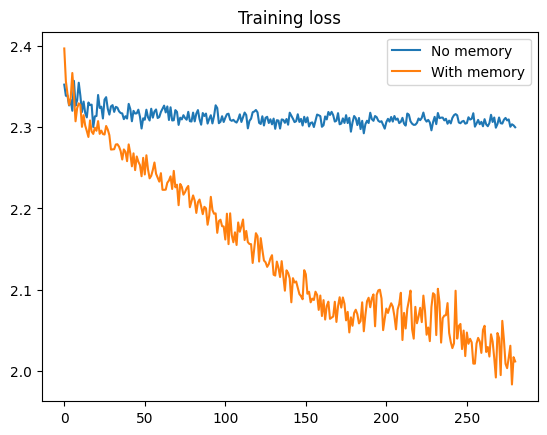

In [19]:
plt.plot(no_mem_losses, label='No memory')
plt.plot(mem_losses, label='With memory')
plt.legend()
plt.title('Training loss');